# SVM and GDA for CIFAR-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

from scipy.spatial.distance import cdist

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [2]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing  
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

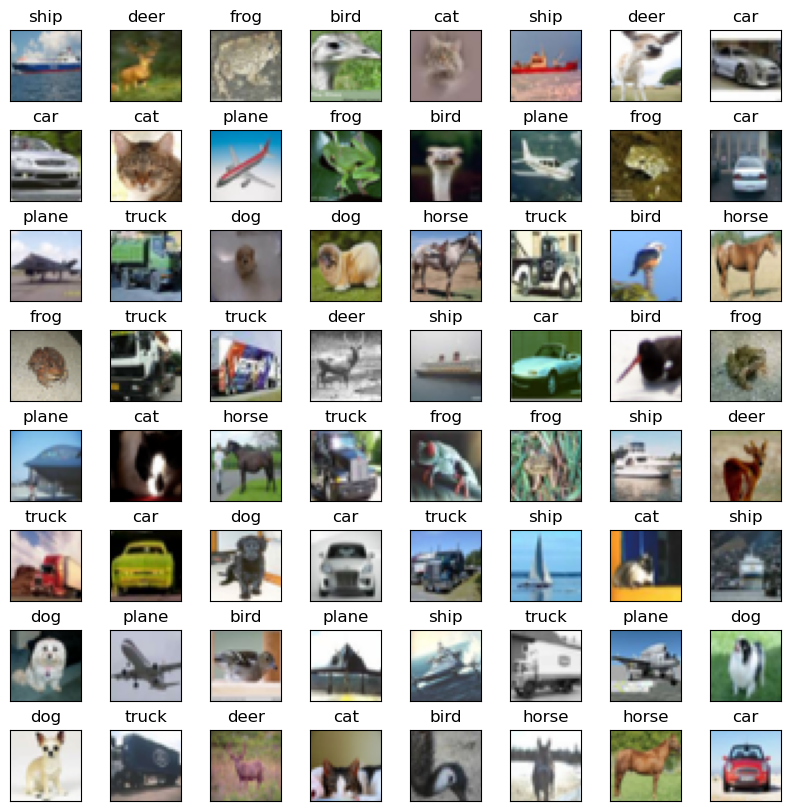

In [3]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0, rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# Accumulate the training, validation, and test sets

In [4]:
def extract_data(generator):
    X = torch.zeros((0,3,32,32))
    y = torch.zeros((0,))
    for (Xtr,ytr) in generator:
        X = torch.vstack([X,Xtr])
        y = torch.concat((y,ytr),axis=0)
    return X,y

Xtrain,ytrain = extract_data(trainloader)
print("Training data: ",Xtrain.shape,ytrain.shape)
Xval,yval = extract_data(valloader)
print("Validation data: ",Xval.shape,yval.shape)
Xtest,ytest = extract_data(testloader)
print("Test data: ",Xtest.shape,ytest.shape)

Training data:  torch.Size([45000, 3, 32, 32]) torch.Size([45000])
Validation data:  torch.Size([5000, 3, 32, 32]) torch.Size([5000])
Test data:  torch.Size([10000, 3, 32, 32]) torch.Size([10000])


# GDA with same covariance for each class (5 points)

Set up an LDA model using sklearn's [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) function (10 points)
    
- set up the LinearDiscriminantAnalysis classifier with 'lsqr' solver and store_covariance=True.
- fit this classifier on the training images (flattened into 50000 x 3072) and labels (50000). 
- evaluate the trained model with the set aside test set using built in functions from sklearn.metrics: accuracy, confusion matrix, classification report (f1 scores). Remember to flatten the test images before running the .predict() function.
- visualize the means of the 10 classes, and interpret the images in relation to the classes they represent. 

In [5]:
# concatenate the train and validation sets for GDA
trainX = torch.vstack((Xtrain,Xval))
trainy = torch.cat([ytrain,yval])
print(trainX.shape,trainy.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [6]:
# your code here (LDA model with same covariance for every class)

# remember to reshape trainX as (50000,3072)
# set up LDA model and fit on (trainX,trainy)
# about 2 lines
X_tr, y_tr = trainX.view(trainX.shape[0], -1).numpy(), trainy.numpy().astype(int)
lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)
lda.fit(X_tr, y_tr)



LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

# Test model on Xtest and ytest (4 points)
- print accuracy of model on (Xtest,ytest)
- print classification report
- print confusion_matrix

In [7]:
#your code here (remember to reshape Xtest)
# about 4 lines
X_te, y_te = Xtest.view(Xtest.shape[0], -1).numpy(), ytest.numpy().astype(int)
y_pred = lda.predict(X_te)
print("Test accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=classes))
print(confusion_matrix(y_te, y_pred))


Test accuracy: 0.3713
              precision    recall  f1-score   support

       plane       0.43      0.46      0.45      1000
         car       0.43      0.41      0.42      1000
        bird       0.26      0.26      0.26      1000
         cat       0.25      0.24      0.25      1000
        deer       0.32      0.27      0.29      1000
         dog       0.30      0.33      0.31      1000
        frog       0.38      0.41      0.40      1000
       horse       0.44      0.40      0.42      1000
        ship       0.47      0.49      0.48      1000
       truck       0.42      0.42      0.42      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.37     10000
weighted avg       0.37      0.37      0.37     10000

[[463  44  51  43  23  41  22  51 192  70]
 [ 65 415  44  51  35  46  38  46  80 180]
 [102  37 256 101 132  91 137  71  49  24]
 [ 43  49 122 245  62 214 132  48  30  55]
 [ 61  28 155  82 271 105 146  98  25  29]
 [ 3

# Visualize the means (1 point)
- comment on the visualizations in this cell. That is, interpret these means in terms of the classes they represent: From the mean images we can start to understand the dominant features of each class that the model will try to pick up on. Clearly, we see that some images (ship, horse) have more dominant features (blue background, long legs) that separate them from other classes, which would allow for the model to have stronger predictive power for those classes.

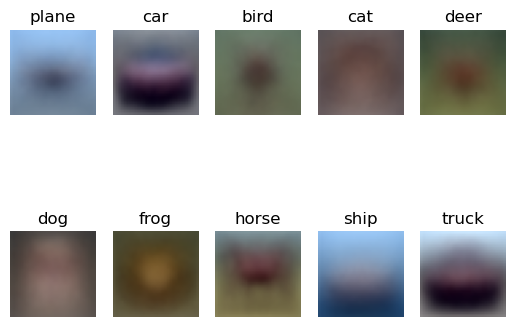

In [8]:
# Run this cell; no code to write.

mean = lda.means_.reshape(10, 32, 32, 3) # 10 x 32 x 32 x 3
class_min, class_max = np.min(lda.means_), np.max(lda.means_)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    tmp = np.transpose(lda.means_[i].reshape((3,32,32)),(1,2,0))
    tmp = (255.0 * (tmp - class_min) / (class_max - class_min)).astype('uint8')
    plt.imshow(tmp)
    plt.axis('off')
    plt.title(classes[i])

plt.show()

# Run SVM on CIFAR10 (40 points)

The sklearn implementation of SVM (SVC) is very slow, because it uses all points in the training set as landmarks. So to speed up the process, we will only use a subset of 5000 images for training.

- build a linear kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train a linear kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build a linear model with that value of C and report accuracy, classification report, and confusion matrix on the full test set. 
- build an RBF kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train an RBF kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build an RBF model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- Comment on performance differences between the two models, if any. 

In [9]:
# subselect 5000 examples from the CIFAR-10 dataset
N = 5000
sXtrain = trainX[:N]
sytrain = trainy[:N]

# Linear SVM kernel
- choosing regularization C using a validation set

In [10]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10])

# your code here for fitting and selecting C (about 6 lines)
Xtr,ytr = sXtrain.view(sXtrain.shape[0],-1).numpy(), sytrain.numpy().astype(int)
Xv,yv   = Xval.view(Xval.shape[0],-1).numpy(), yval.numpy().astype(int)
models = [SVC(kernel='linear', C=c, probability=False).fit(Xtr, ytr) for c in C_vals]
accs   = [m.score(Xv, yv) for m in models]
best_C = C_vals[np.argmax(accs)]
print("Best C (linear):", best_C, "val acc:", max(accs))

Best C (linear): 0.001 val acc: 0.3792


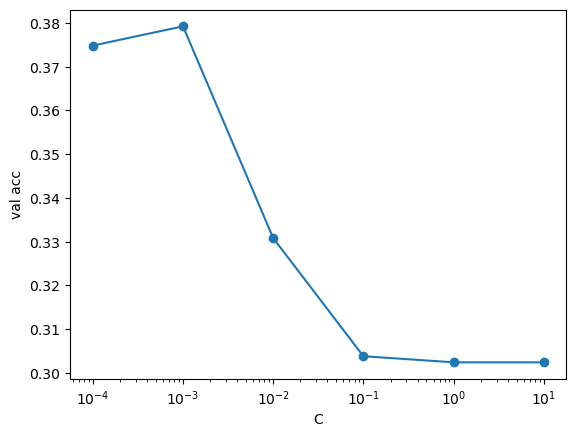

In [11]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
plt.semilogx(C_vals, accs, marker='o'); plt.xlabel('C'); plt.ylabel('val acc'); plt.show()


In [12]:
# build model with best value of C
# print test accuracy, confusion matrix and classification report on test set
# about 5 lines of code
best_linear = SVC(kernel='linear', C=best_C, probability=False).fit(Xtr, ytr)
X_te, y_te = Xtest.view(Xtest.shape[0], -1).numpy(), ytest.numpy().astype(int)
y_pred = best_linear.predict(X_te)
print("Test accuracy:", accuracy_score(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=classes))


Test accuracy: 0.3713
[[458  46  87  35  24  39  25  30 193  63]
 [ 77 403  58  55  27  41  40  44  96 159]
 [ 94  40 326 109  93  56 160  53  57  12]
 [ 39  52 148 259  49 188 136  47  37  45]
 [ 65  21 196  80 248  73 204  70  24  19]
 [ 41  26 149 155  77 321 114  49  45  23]
 [ 22  37 120 143  73  69 480  20  14  22]
 [ 61  37 115 103 137  65  66 315  30  71]
 [199  59  45  44  13  44  13  12 485  86]
 [ 85 177  23  50  21  24  47  46 109 418]]
              precision    recall  f1-score   support

       plane       0.40      0.46      0.43      1000
         car       0.45      0.40      0.42      1000
        bird       0.26      0.33      0.29      1000
         cat       0.25      0.26      0.25      1000
        deer       0.33      0.25      0.28      1000
         dog       0.35      0.32      0.33      1000
        frog       0.37      0.48      0.42      1000
       horse       0.46      0.32      0.37      1000
        ship       0.44      0.48      0.46      1000
      

# RBF SVM kernel
- choosing regularization C using a validation set

In [15]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10])

# your code here for fitting and selecting C (about 6 lines)
Xtr,ytr = sXtrain.view(sXtrain.shape[0],-1).numpy(), sytrain.numpy().astype(int)
Xv,yv   = Xval.view(Xval.shape[0],-1).numpy(), yval.numpy().astype(int)
models = [SVC(kernel='rbf', C=c, probability=False).fit(Xtr, ytr) for c in C_vals]
accs   = [m.score(Xv, yv) for m in models]
best_C = C_vals[np.argmax(accs)]
print("Best C (rbf):", best_C, "val acc:", max(accs))

Best C (rbf): 10.0 val acc: 0.454


In [14]:
# your code here
# build best RBF model with best value of C
# report test set accuracy, confusion matrix and classification report on test set
# about 6 lines of code
best_rbf = SVC(kernel='rbf', C=best_C, probability=False).fit(Xtr, ytr)
X_te, y_te = Xtest.view(Xtest.shape[0], -1).numpy(), ytest.numpy().astype(int)
y_pred = best_rbf.predict(X_te)
print("Test accuracy:", accuracy_score(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=classes))


Test accuracy: 0.4379
[[522  55  81  25  37  23  26  24 148  59]
 [ 55 549  21  62  20  29  17  28  75 144]
 [ 86  29 367  91 130  76 101  66  31  23]
 [ 34  38  97 304  61 213 116  55  27  55]
 [ 46  19 200  81 346  68 117  76  29  18]
 [ 29  31 119 249  76 329  69  56  19  23]
 [ 18  21 137 134 101  55 474  24  17  19]
 [ 53  44  70  90  97  88  42 410  20  86]
 [117  79  26  63  23  18  12  14 587  61]
 [ 76 189  15  41  14  31  24  43  76 491]]
              precision    recall  f1-score   support

       plane       0.50      0.52      0.51      1000
         car       0.52      0.55      0.53      1000
        bird       0.32      0.37      0.34      1000
         cat       0.27      0.30      0.28      1000
        deer       0.38      0.35      0.36      1000
         dog       0.35      0.33      0.34      1000
        frog       0.47      0.47      0.47      1000
       horse       0.52      0.41      0.46      1000
        ship       0.57      0.59      0.58      1000
      

# Comment on linear SVM vs RBF kernel SVM
- I expect an RBF kernel to outperform a linear kernel when the true decision boundary is nonlinear and based on the performance comparisons, that seems to be the case.
- The RBF model preferred a larger C, indicating a smaller tolerance of margin violations. The RBF kernel allows for more flexibility in the decision boundary than the linear kernel, therefore it makes sense that the RBF kernel preferred a larger C than the linear kernel.
- These images have complex relationships, the more flexible kernel (RBF) is better suited to such classification problems. 
